# Problem set 2 (45 + 50 + 33 + 15 = 143 pts)

## Problem 1 (LU decomposition) 45 pts


### 1. LU  for band matrices and Cholesky decomposition (13 pts)

The complexity to find an LU decomposition of a dense $n\times n$ matrix is $\mathcal{O}(n^3)$.
Significant reduction in complexity can be achieved if the matrix has a certain structure, e.g. it is sparse. 
In the following task we consider an important example of $LU$ for a special type of matrices –– band matrices with top left entry equal to 1 and the bandwidth $m$ equal to 3 or 5 which called tridiagonal and pentadiagonal respectively. The bands may be ```[1, 2, 1]``` and ```[1, 1, 2, 1, 1]``` respectively

- (4 pts) Write a function ```band_lu(diag_broadcast, n)``` which computes LU decomposition for tridiagonal or pentadiagonal matrix with top left entry equal to 1 with given diagonal bands. 
For example, input parametres ```(diag_broadcast = [1,2,1], n = 4)``` mean that we need to find LU decomposition for the triangular matrix of the form:

$$A = \begin{pmatrix}
1 & 1 & 0 & 0\\
1 & 2 & 1 & 0 \\
0 & 1 & 2 & 1 \\
0 & 0 & 1 & 2 \\
\end{pmatrix}.$$

Provide the extensive testing of the implemented function that will works correctly for large $n$,  e.g. $n=100$.
As an output it is considered to make ```L``` and ```U``` - 2D arrays representing diagonals in factors $L$ (```L[0]``` keeps first lower diagonal, ```L[1]``` keeps second lower, ...), and $U$ (```U[:,0]``` keeps main diagonal, ```U[:,1]``` keeps first upper, ...).

- (2 pts) Compare execution time of the band LU decomposition using standard function from ```scipy```, i.e. which takes the whole matrix and does not know about its special structure, and band decomposition of yours implementation. Comment on the results.

- (7 pts) Write a function ```cholesky(n)``` for computing Cholesky decomposition. It should take the the single argument - the matrix that will be factorized and return the single output - lower-triangular factor $L$. Think about the efficiency of your implementation and if necessary update it to achieve the best performance (eliminate Python loops, where it is possible and so on). Explicitly describe the difference with LU decomposition that reduces the complexity from $2n^3/3$ for LU to $n^3/3$ for Cholesky. 
Test the implemented function on the Pascal matrix of given size $n$ for $n = 5, 10, 50$. 
Pascal matrix is square matrix of the following form (here for $n=4$)
$$P = \begin{pmatrix}
1 & 1 & 1 & 1\\
1 & 2 & 3 & 4 \\
1 & 3 & 6 & 10 \\
1 & 4 & 10 & 20 \\
\end{pmatrix}.$$

    [Here](https://en.wikipedia.org/wiki/Pascal_matrix) you can find more details about such matrices and analytical form for factor $L$ from Cholesky decomposition. Compare the result of your implementation with analytical expression in terms of some matrix norm of difference.  

In [103]:
from scipy.sparse import diags # can be used with broadcasting of scalars if desired dimensions are large
import numpy as np

# INPUT : diag_broadcast - list of diagonals value to broadcast,length equal to 3 or 5; n - integer, 
#                               band matrix shape.
# OUTPUT : L - 2D np.ndarray, 
#                L.shape[0] depends on bandwidth, 
#                L.shape[1] = n-1, do not store main diagonal, where all ones;                  
#                add zeros to the right side of rows to handle with changing length of diagonals.
#          U - 2D np.ndarray, U.shape[0] = n, U.shape[1] depends on bandwidth;
#              add zeros to the bottom of columns to handle with changing length of diagonals.

def band_lu(diag_broadcast, n):
    if len(diag_broadcast) != 3:
        if len(diag_broadcast) != 5:
            raise ValueError("Expecting a band of size 3 or 5")

    band = len(diag_broadcast)
    m = band // 2
    L = np.zeros((m, n - 1))
    U = np.zeros((n, m + 1))
    
    U[:, :] = diag_broadcast[m:]
    U[0, 0] = 1
    a0 = diag_broadcast[0]
    a1 = diag_broadcast[1]
    a = a1 if band == 5 else a0
    
    for i in range(n - 1):
        if abs(U[i, 0]) < 1e-10:
            raise ValueError("pivot values are small")
        
        if i == 0:
            u00val = 1 
        else:
            u00val =  U[i, 0]
        L[0, i] = a / u00val
        U[i + 1, 0] -= L[0, i] * U[i, 1]
        if i != n - 2 and band == 5:
            L[1, i] = a0 / u00val
            U[i + 1, 1] -= L[0, i] * U[i, 2]
            U[i + 2, 0] -= L[1, i] * U[i, 2]
            a = a1 - L[1, i] * U[i, 1]
    return L, U   


def ground_truth(diag, N):
    m = len(diag) // 2
    diag_z = diag + [0 for _ in range(N - len(diag))]
    A = np.asarray([np.roll(diag_z , i - m) for i in range(N)])
    for i in range(m + 1, N):
        for j in range(0, i - m):
            A[i,j] = 0
    A[0, 0] = 1
    A[0, -1] = 0
    return A

def test_correctness(diag, N):
    L, U = band_lu(diag, N)
    L = (diags(L, [-1]).todense() + np.identity(N))
    U = diags(U.T, [0, 1]).todense()

    trueval = ground_truth(diag, N)
    res = np.allclose(trueval, L@U)
    return res

In [32]:
""" Check for correctness """

from random import randint

correct = []
k = 0
for i in range(10, 400):
    k += 1
    r = test_correctness([randint(0, 1000), 
                          randint(0, 1000), 
                          randint(0, 1000)], 
                                     i)
    # print("iter {} is {}\n".format(k,r))
    correct.append(r)
print(all(correct))

k = 0
for i in range(10, 400):
    k += 1
    r = test_correctness([1e3, 
                          1e-3, 
                          1e-3], 
                                     i)
    # print("iter {} is {}\n".format(k,r))
    correct.append(r)
print(all(correct))

True
True


In [86]:
"""
Compare execution time of the band LU decomposition 
using standard function from scipy, 
i.e. which takes the whole matrix and does not know about its special structure, 
and band decomposition of yours implementation. Comment on the results.
"""

from scipy.linalg import lu
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

def do_cholesky_time_cmp(diag, Ns):
    ts = [[], []]
    for n in Ns:
        A = ground_truth(diag, n)
        t = %timeit -o -q -n 5 lu(A)
        ts[0].append(np.mean(t.timings))
        t = %timeit -o -q -n 5 band_lu(diag, n)
        ts[1].append(np.mean(t.timings))

    figure(figsize=(8, 6), dpi=80)
    plt.plot(ts[0], label='scipy')
    plt.plot(ts[1], label='band')
    plt.ylabel('sec')
    plt.xlabel('N')
    plt.xticks(ticks=([i for i,_ in enumerate(Ns)]),labels=Ns, rotation=90)
    plt.legend()
    plt.show()

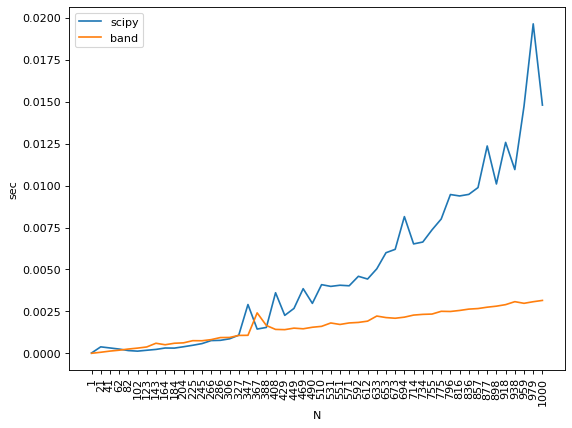

5

In [104]:
test = [1,25,16,500,31]
Ns = np.linspace(1, 1000, 50, dtype=int)
# [i for i,_ in enumerate(Ns)]
do_cholesky_time_cmp(test, Ns)
test.__len__()

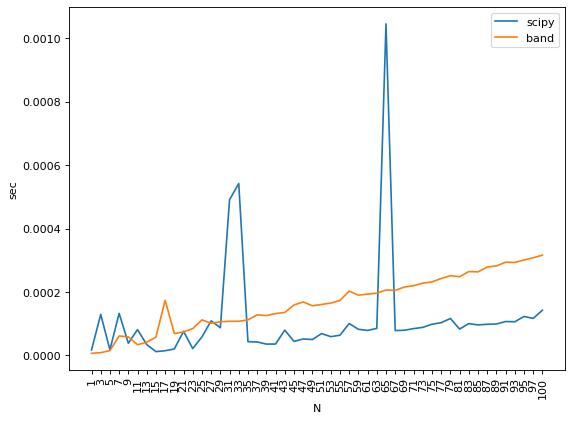

In [107]:
Ns = np.linspace(1, 100, 50, dtype=int)
do_cholesky_time_cmp(test, Ns)

In [108]:
A = diags([1, 2, 3], [-1, 0, 1], shape=(10000, 10000)).todense()
%timeit lu(A)
%timeit band_lu(np.array([1, 2, 3]), n=10000)

We see that when N is small, the two methods are comparable in tiome. This is due to the fact that there is not much of a difference between the amoubt of operations. For small N (apparently, N < 300), The matrix is "not sparse enough". 

However, we see an exponential growth of time needed for a calculation when we take a big N. This makes sense as the `schipy.linalg.lu` does PLU factorization (without Strassen) and the time complexity is O(n3). 

For the implementation above the time complexity is approximately O(n):(O((0.5*bandwidth)^2 * n))

- (7 pts) Write a function ```cholesky(n)``` for computing Cholesky decomposition. It should take the the single argument - the matrix that will be factorized and return the single output - lower-triangular factor $L$. Think about the efficiency of your implementation and if necessary update it to achieve the best performance (eliminate Python loops, where it is possible and so on). Explicitly describe the difference with LU decomposition that reduces the complexity from $2n^3/3$ for LU to $n^3/3$ for Cholesky. 
Test the implemented function on the Pascal matrix of given size $n$ for $n = 5, 10, 50$. 
Pascal matrix is square matrix of the following form (here for $n=4$)
$$P = \begin{pmatrix}
1 & 1 & 1 & 1\\
1 & 2 & 3 & 4 \\
1 & 3 & 6 & 10 \\
1 & 4 & 10 & 20 \\
\end{pmatrix}.$$

    [Here](https://en.wikipedia.org/wiki/Pascal_matrix) you can find more details about such matrices and analytical form for factor $L$ from Cholesky decomposition. Compare the result of your implementation with analytical expression in terms of some matrix norm of difference.  

In [103]:
import numpy as np
from scipy.linalg import pascal

def cholesky_py(A):
    B = A.copy().astype('float64')
    L = np.array([[0] * len(B) for _ in enumerate(B)])
    for i, (Ai, Li) in enumerate(zip(B, L)):
        for j, Lj in enumerate(L[:i+1]):
            s = sum(Li[k] * Lj[k] for k in range(j))
            if i == j:
                Li[j] = (Ai[i] - s) ** 0.5
            else:
                Li[j] = ((1.0 / Lj[j]) * (Ai[j] - s))
        # print(L)
    return L

def test_cholesky(A):
    L = cholesky_py(A)
    # print(A)
    reconst = L@L.conj().T
    # print(reconst)
    return np.linalg.norm(A - reconst, ord='fro') / np.linalg.norm(A, ord='fro')

def cholesky_dbg(A):
    B = A.copy().astype('float64')
    L = np.array([[0] * len(B) for _ in enumerate(B)])
    for i, (Ai, Li) in enumerate(zip(B, L)):
        for j, Lj in enumerate(L[:i+1]):
            s = sum(Li[k] * Lj[k] for k in range(j))
            if i == j:
                if i>=28:
                    print(i)
                    print(sum([Li[k]**2 for k in range(j)]))
                Li[j] = (Ai[i] - s) ** 0.5
            else:
                Li[j] = ((1.0 / Lj[j]) * (Ai[j] - s))
        # print(L)
    return L


In [104]:
test_cholesky(pascal(5))

test = [4,5,10,25, 26, 27, 28, 29, 30,31]
for N in test:
    print("relative error of Cholesky descomposition for N = {} is {}\n".format(N,
          test_cholesky(pascal(N))))


relative error of Cholesky descomposition for N = 4 is 0.0

relative error of Cholesky descomposition for N = 5 is 0.0

relative error of Cholesky descomposition for N = 10 is 0.0

relative error of Cholesky descomposition for N = 25 is 0.0

relative error of Cholesky descomposition for N = 26 is 0.0

relative error of Cholesky descomposition for N = 27 is 0.0

relative error of Cholesky descomposition for N = 28 is 0.0

relative error of Cholesky descomposition for N = 29 is 0.0

relative error of Cholesky descomposition for N = 30 is 1.9991937281298968e-16



/tmp/ipykernel_5253/3714146401.py:11: RuntimeWarning: invalid value encountered in double_scalars
  Li[j] = (Ai[i] - s) ** 0.5


ValueError: cannot convert float NaN to integer

In [107]:
def binomialCoeff(n, k):
    C = [[0 for i in range(k + 1)]
         for i in range(n + 1)]
    for i in range(n + 1):
        for j in range(min(i, k) + 1):
            if (j == 0 or j == i):
                C[i][j] = 1
            else:
                C[i][j] = C[i - 1][j - 1] + C[i - 1][j]
    return C[n][k]

"""
s = sum(Li[k] * Lj[k] for k in range(j))
if i == j:
    Li[j] = (Ai[i] - s) ** 0.5
else:
    Li[j] = ((1.0 / Lj[j]) * (Ai[j] - s))
"""

ord = 31
pas = pascal(ord)

roww = [binomialCoeff(ord-1,i) for i in range(ord-1)]
coll = roww.copy()
s = sum(roww[k] * coll[k] for k in range(ord-1))

print("the sum of prefious row and column is {}".format(s))
print("the Aii element, where i ={} is {}".format(ord, pas[-1,-1]))
print("the Lii element, where i ={} should be 1. Calculated: {}".format(ord, (pas[-1,-1] - s)**0.5))

the sum of prefious row and column is 118264581564861423
the Aii element, where i =31 is 118264581564861424
the Lii element, where i =31 should be 1. Calculated: 0.0


In [102]:
cholesky_dbg(pas)
[]

28
7648690600760439.0
29
3.0067266499541216e+16
30
nan


/tmp/ipykernel_5253/2341743114.py:34: RuntimeWarning: invalid value encountered in double_scalars
  Li[j] = (Ai[i] - s) ** 0.5


[]

For N > 30, we encounter a problem with python not being able to calculate the 31th row of the L matrix and onward. 

The `L[31,31]` element is calculated as `NaN` beacause the dot product of 30'th column and row is quite large. Summation and subtraction have a huge error when performing float-point operations on such big numbers (1e17).

When operating in integers, values come close to int64 overflow. As we do a summation over a list, this is critical.

### 2. Stability of LU (8 pts)

* (4 pts) Show, that for these  matrices $A$ and $B$ LU decomposition fails. Why does it happen?



$
A = \begin{pmatrix}
0 & 1 \\
2 & 3
\end{pmatrix}.$ 

$B = \begin{pmatrix}
1 & 1 & 0\\
1 & 1 & 2 \\
1 & 2 & 1
\end{pmatrix}.$ 

__SOLUTION__ for above:\
\
For matrix A, `A[0,0]` is zero. We can't do LU decompostition with a pivoting value == 0 as Gaussian Elimination would require a division by zero, the result of which is not defined. 

For matrix B, note that 2nd leading principle is all ones, so it has linearly dependend colums, wich indicates that this submatrix is singular. The singularity of leading principle submatrix indicates that the LU decomposition is not gurarnteed, but still may exist. 

However, the matrix cosinsts of all ones. This meanst that after the first step of elimination we have a zero element on a main diagonal in the second row of U, which means that for futher sterps we are forced to divide by zero. 

In [110]:
from scipy.linalg import lu, pascal
import numpy as np 

def regular_lu(A):
    #Get the number of rows
    n = A.shape[0] 
    # print(n)
    U = A.copy()
    # print(U)
    L = np.eye(n, dtype=np.double)

    for i in range(n):
        print(U)
        factor = U[i+1:, i] / U[i, i]
        print(factor)
        print(i)
        L[i+1:, i] = factor
        U[i+1:] -= factor[:, np.newaxis] * U[i]
        # print(U[i+1:])
        # print("------------------")
    return L, U

B = np.array([ [1, 1, 0],
               [1, 1, 2],
               [1, 2, 1]
             ])
L,U = regular_lu(B.astype('double'))


[[1. 1. 0.]
 [1. 1. 2.]
 [1. 2. 1.]]
[1. 1.]
0
[[1. 1. 0.]
 [0. 0. 2.]
 [0. 1. 1.]]
[inf]
1
[[  1.   1.   0.]
 [  0.   0.   2.]
 [ nan  nan -inf]]
[]
2


/tmp/ipykernel_7263/3605595289.py:14: RuntimeWarning: divide by zero encountered in true_divide
  factor = U[i+1:, i] / U[i, i]
/tmp/ipykernel_7263/3605595289.py:18: RuntimeWarning: invalid value encountered in multiply
  U[i+1:] -= factor[:, np.newaxis] * U[i]


* (4 pts) In the LU decomposition, a pivot position is a position of the element that identifies the row and column that will be eliminated in the current step. For example, first pivot in LU is usually the left top element. What value of $c$ leads to zero in the second pivot position? What $c$ produces zero in the third pivot position? What modification of LU should we use in order to address the possible zeros in pivot position?

$A = \begin{pmatrix}
1 & c & 0\\
2 & 4 & 1 \\
3 & 5 & 1
\end{pmatrix}.$ 

In [114]:
import numpy as np 

def regular_lu(A):
    #Get the number of rows
    n = A.shape[0] 
    # print(n)
    U = A.copy()
    # print(U)
    L = np.eye(n, dtype=np.double)

    for i in range(n):
        factor = U[i+1:, i] / U[i, i]
        L[i+1:, i] = factor
        U[i+1:] -= factor[:, np.newaxis] * U[i]

    return L, U

c = 2
A = np.array([ [1, c, 0],
               [2, 4, 1],
               [3, 5, 1]
             ], np.double)

print(A)
L, U = regular_lu(A)

[[1. 2. 0.]
 [2. 4. 1.]
 [3. 5. 1.]]


/tmp/ipykernel_7263/3010989784.py:14: RuntimeWarning: divide by zero encountered in true_divide
  factor = U[i+1:, i] / U[i, i]
/tmp/ipykernel_7263/3010989784.py:17: RuntimeWarning: invalid value encountered in multiply
  U[i+1:] -= factor[:, np.newaxis] * U[i]


For us not to be able to perform a classic LU on this matrix, we need the 2-nd order leading principle matrix to have linearly dependent rows.\
$A = \begin{pmatrix}
1 & c \\
2 & 4
\end{pmatrix}.$ \

We can clearly see that this would be `c=2`.

To do an LU decomposition of such a matrix, we resort to pivoting (a PLU decomposition).

In [113]:
from scipy.linalg import lu

c = 2
A = np.array([ [1, c, 0],
               [2, 4, 1],
               [3, 5, 1]
             ], np.double)

P, L, U = lu(A)
P@L@U

array([[1., 2., 0.],
       [2., 4., 1.],
       [3., 5., 1.]])

### 3. Implementation of PLU decomposition (14 pts)

As you have noticed before, LU decomposition may fail. In order to make it stable, we can use LU decomposition with pivoting  (PLU).

We want to find such permutation matrix $P$ that LU decomposition of $PA$ exists

$$ PA = LU $$

- (7 pts) Implement efficiently PLU decomposition (without loops and with appropriate level of BLAS operations).  Also, pay attention to the way of permutation matrix storage.

- (4 pts ) Compare your function for computing PLU with built-in function on matrices of such type ```(mirror_diag = [1,2,1], n = 4)```. (Bandwidth and matrix size may vary). So, you can pass them as dense 2D NumPy array and do not tune your implementation to this special structure. Compare them in terms of running time (use ```%timeit``` magic) for range of dimensions to recover the asymptotic rate of time increasing and in terms of acuracy. We expect you plot the running time vs matrix dimension for built-in function and your implementation. So you should get the plot with two lines.
Consider additionally one of the pathological examples from above, where LU fails, but PLU has to work.


$$A = \begin{pmatrix}
0 & 0 & 1 & 1 \\
 0 &1 & 2 & 1  \\
 1 & 2 & 1  & 0\\
1 & 2  & 0 & 0  \\
\end{pmatrix}.$$


- (3 pts) Discuss the obtained results and explain how is it possible to accelerate computing the PLU factorization. 

NumPy or JAX are both ok in this problem, but please use the single library for all implementations. 

In [54]:
import numpy as np 
from scipy.linalg import lu, pascal
from matplotlib.pyplot import figure 
import matplotlib.pyplot as plt 


def pivot_lu(A):
    n = A.shape[0]
    
    U = A.copy()
    P = np.eye(n)
    L = P.copy()
    
    PF = L.copy()
    LF = np.zeros((n,n))
    
    for k in range(n - 1):
        index = np.argmax(abs(U[k:,k])) + k 
        if index != k:
            P = np.eye(n)
            P[[index,k],k:n] = P[[k,index],k:n]
            U[[index,k],k:n] = U[[k,index],k:n] 
            PF = np.dot(P,PF)
            LF = np.dot(P,LF)
        
        L = np.eye(n)
        LF[k+1:,k] = (U[k+1:,k] / U[k,k])
        L[k+1:,k]  = -1 * LF[k+1:,k]
        U = np.dot(L,U)
        
    np.fill_diagonal(LF, 1)
    return PF.T, LF, U

In [61]:
# A = np.array([ [1, 2, 0],
#                [2, 4, 1],
#                [3, 5, 1]
#              ], np.double)

A = pascal(25).astype('double')
pp, lp, up = pivot_lu(A)
ps, ls, us = lu(A)
print(np.isclose((pp@lp@up), A).all())
print(np.isclose((ps@ls@us), A).all())

True
True


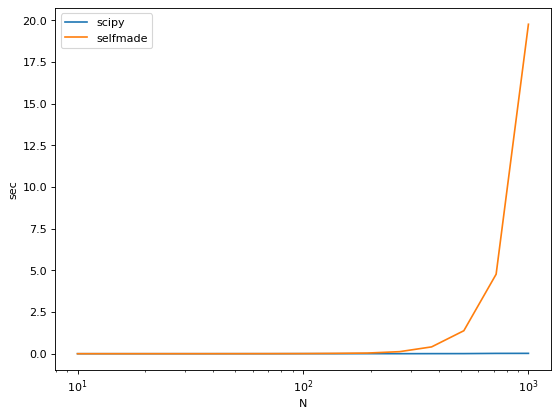

In [56]:
def construct_minor_diag_mat(diag, N):
    m = len(diag) // 2
    diag_z = diag + [0 for _ in range(N - len(diag))]
    A = np.asarray([np.roll(diag_z , i - m) for i in range(N)])
    for i in range(m + 1, N):
        for j in range(0, i - m):
            A[i,j] = 0
    A[0, 0] = 1
    A[0, -1] = 0
    return np.rot90(A)

def do_pivlu_time_cmp(Ns):
    ts = [[], []]
    for n in Ns:
        A = construct_diag_mat([1,2,1], n)
        t = %timeit -o -q -n 5 lu(A)
        ts[0].append(np.mean(t.timings))
        t = %timeit -o -q -n 5 pivot_lu(A)
        ts[1].append(np.mean(t.timings))

    figure(figsize=(8, 6), dpi=80)
    plt.semilogx(Ns, ts[0], label='scipy')
    plt.semilogx(Ns, ts[1], label='selfmade')
    plt.ylabel('sec')
    plt.xlabel('N')
    plt.legend()
    plt.show()

Ns = np.logspace(1, 3, 15, dtype=int)
do_pivlu_time_cmp(Ns)

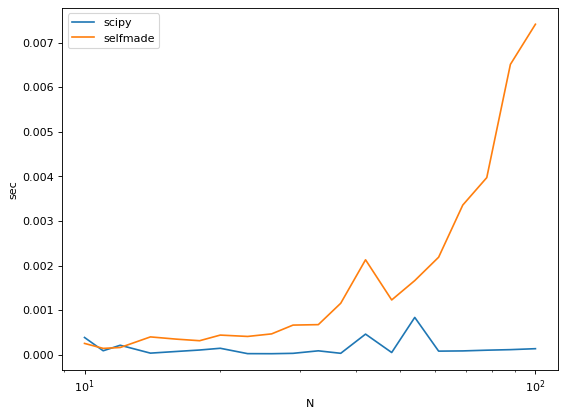

In [55]:

Ns = np.logspace(1, 2, 20, dtype=int)
do_pivlu_time_cmp(Ns)

Seems like the `scipy.linalg.lu` accomplishes the PLU decomposition in O(1), while the self-made code takes exponentially more time than that when the N rises. 

Assuming that the input matrix is dense, while analyzing the code, one can infer that the time complexity is O(n^3): There is a cycle, at each iteration of which a dot product of 2 matrices is taken. Assuming that the dot product has a time complexity O(n^2), putting it into the loop would make it O(n^3). 

### 4. Block LU (10 pts)

Let $A = \begin{bmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{bmatrix}$ be a block matrix. The goal is to solve the linear system

$$
     \begin{bmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{bmatrix} \begin{bmatrix} u_1 \\ u_2 \end{bmatrix} = \begin{bmatrix} f_1 \\ f_2 \end{bmatrix}.
$$

* (2 pts) Using block elimination find matrix $S$ and right-hand side $\hat{f_2}$ so that $u_2$ can be found from $S u_2 = \hat{f_2}$. Note that the matrix $S$ is called <span style="color:red">Schur complement</span> of the block $A_{11}$.

Let's do a block LU decomposition of A:
$ A = \begin{bmatrix} 
A_{11} & A_{12} \\ A_{21} & A_{22} \end{bmatrix} = \begin{bmatrix} 
L_{11} & 0 \\ L_{21} & L_{22} \end{bmatrix} \begin{bmatrix} 
U_{11} & U_{12} \\ 0 & U_{22} \end{bmatrix} = \begin{bmatrix} 
L_{11} U_{11} & L_{11} U_{12} \\ L_{21} U_{11} & L_{21} U_{12} + L_{22} U_{22} \end{bmatrix} $\
\
$U_{12} = L^{-1}_{11} A_{12}$

$L_{21} = A_{21} U^{-1}_{11} $

$ L_{22} U_{22} = A_{22} - L_{21} U_{12} = A_{22} - A_{21} U^{-1}_{11} L^{-1}_{11} A_{12} = A_{22} - A_{21} A^{-1}_{11} A_{12}$

$\begin{bmatrix} 
L_{11} U_{11} & L_{11} U_{12} \\ 
L_{21} U_{11} & L_{21} U_{12} + L_{22} U_{22} 
\end{bmatrix} 
\begin{bmatrix} 
u_1 \\ 
u_2 
\end{bmatrix} = \begin{bmatrix} 
f_1 \\ 
f_2 
\end{bmatrix} \rightarrow \begin{equation}
\begin{aligned}
&L_{11}U_{11}u_1 + L_{11}U_{12} u_2 = f_1 \\
&L_{21}U_{11}u_1 + (L_{21}U_{12}+L_{22}U_{22}) u_2 = f_2
\end{aligned}
\end{equation}$\
\
$A_{11}u_1 + A_{12}u_2 = f_1 \implies u_1 = A_{11}^{-1}(f_1 - A_{12}u_2)$

$A_{21}u_1 + A_{22}u_2 = f_2 \implies A_{22}u_2 = f_2 - A_{21}u_1 = f_2 - A_{21}(A_{11}^{-1}(f_1 - A_{12}u_2)) = f_2 - A_{21}A_{11}^{-1}f_1 + A_{21}A_{11}^{-1}A_{12}u_2 $

$(A_{22}−A_{21}A^{−1}_{11}A_{12})u_2 = f_2−A_{21}A^{−1}_{11}f_1$, or in other words $L_{22}U_{22} = S$

Answer:

$S = A_{22}−A_{21}A^{−1}_{11}A_{12}\\
\hat f_2 = f_2−A_{21}A^{−1}_{11}f_1$

***
* (4 pts) Using Schur complement properties prove that 

$$\det(X+AB) = \det(X)\det(I+BX^{-1}A), $$
where $X$ - nonsingular square matrix.

`fueled by` [`a random hepfulpaper`](https://terrytao.wordpress.com/2013/01/13/matrix-identities-as-derivatives-of-determinant-identities/#schurd) ` on a Schur determinant identity`

Consider $\begin{bmatrix} X & A \\ -B & I \end{bmatrix} = 
\begin{bmatrix}
X & 0 \\
-B & I
\end{bmatrix}
\begin{bmatrix}
I & X^{-1} A \\
0 & I+B X^{-1} A
\end{bmatrix}=\begin{bmatrix}
X+A B & A \\
0 & I
\end{bmatrix}
\begin{bmatrix}
I & 0 \\
-B & I
\end{bmatrix}$\
\
Since $\det\Big(\begin{matrix}
A & B \\
0 & C
\end{matrix}\Big)= \det(A) \det(C)$, _and_ while keeping in mind the standard way to compute a 2x2 determinant, we can write down
$\det\Big(\begin{matrix}
X & A \\
-B & I
\end{matrix}\Big)=\det(X+A B)=\det(X) \det\Big(I+B X^{-1} A\Big)$ QED.
***

* (4 pts) Let matrix $F \in \mathbb{R}^{m \times n}$ and $G \in \mathbb{R}^{n \times m}$. Prove that 

$$\det(I_m - FG) = \det(I_n - GF).$$

From the previous subtask, recall that $\det(X+AB) = \det(X)\det(I+BX^{-1}A)$ \
1. Assume that 
    - $I_m = X$, 
    - $-F= A$, 
    - $G = B$. 
2. Then,  $\det(I_m -FG) = \det(I_m)\det(I_n + GI_m(-F)) = \det(I_n - GF)$ QED.

## Problem 2 (eigenvalues)  (50 pts)

### 1. Theoretical tasks (15 pts)
---
* (2 pts) Prove that eigenvectors that correspond to distinct eigenvalues are linearly independent.

Let $[v_1,v_2\dots,v_n]$ be eigenvectors corresponding to distinct eigenvalues $[\lambda_1,\lambda_2,\dots,\lambda_n]$. 

Let's study a set of power $k$ of eigenvectors  $[\lambda_1,\lambda_2,\dots,\lambda_k]$, where $0\le k\le n$; while considering _some_ linear transformation $L: \mathbb{C}^{n\times n} \rightarrow \mathbb{C}^{n\times n}$\
1. If k = 0, set is empty $\Rightarrow$ lin independend by definition.
2. If k = 1, set is lin indep. as it contains only one non-zero (eigenvercotrs are non-zero by definition) vector
3. $1 < k\le n$, base case of  k = 2: \
    Suppose that v1 and v2 correspond to different eigenvalues. We take a linear combination $a_1 v_1 + a_2 v_2 = 0$. Since eigenvectors are distinct. \
    $L(a_1 v_1 + a_2 v_2) = L(0) = 0$\
    $0 = L(a_1 v_1 + a_2 v_2) = a_1\lambda_1v_1 + a_2\lambda_2 v_2$. From this follows that the 2 equations are true: \
    $0 = a_1\lambda_1v_1 + a_2\lambda_2 v_2$\
    $0 = a_1\lambda_1v_1 + a_2\lambda_2 v_2$\
    hence, \
    $0  = a_2(\lambda_2 - \lambda_1)v_2$. Since $\lambda_2 \not= \lambda_1$ and since $v_2\not=0$ (by definition of en eigenvector), a_2 must be 0. Since $a_1 v_1 + a_2 v_2 = 0$, a_1 should also be 0.\
    \
    So bot a_1 and a_2 are zero while eigenvalues are not. Given the linear combination we've studied, v_1 and v_2 are linearly independent. 
    
4. $2 < k\le n$, induction step: \
    Assume there are 2 linearly independent eingenvectors and the third is dependent.
    $v_3 = a_1 v_1 + a_2 v_2$. Then, \
    $Lv_3 = \lambda_3a_1 v_1 + \lambda_3 a_2 v_2$\
    We recall that $v_1 = \frac{1}{\lambda_1}Lv_1$ and $v_2 = \frac{1}{\lambda_2}Lv_2$. Substitution:\
    $Lv_3 = \frac{\lambda_3 a_1}{\lambda_1}Lv_1 + \frac{\lambda_3 a_2}{\lambda_2}Lv_2 \Rightarrow $\
    $v_3 = \frac{\lambda_3 a_1}{\lambda_1}v_1 + \frac{\lambda_3 a_2}{\lambda_2}v_2$. Since we assumed that v_3 is lin. combination of v_1 and v_2 ($v_3 = a_1 v_1 + a_2 v_2$), we get that:\
    $\frac{\lambda_3 a_1}{\lambda_1} = a_1$ and $\frac{\lambda_3 a_2}{\lambda_2} = a_2$, so\
    $\lambda_3 = \lambda_1 $ and $\lambda_3 = \lambda_2$, but the initial assumption is that eigenvalues are distinct. Ergo contradiction. 
    
Since we've proven that at least 2 eigenvectors with distinct values are lin. indep, and that the third cannot be a linear combination of the another 2, we can safely say, that: 
    We can get the same contradinction from the induction step for any triplets of eigenvectors, and for each one of them it would be clear that is is linearly independent of the other 2. This way every eigenvector is linearly independent of each other. QED

---
* (3 pts) $A$ is a matrix such that $a_{i,j} \ge 0$ and $\sum_{j}a_{i,j} = 1$ (sum of the elements in each row is 1). Prove that $A$ has an eigenvalue $\lambda=1$ and that any eigenvalue $\lambda_i$: $|\lambda_i| \le 1$.

$Av = v$ if $v = [1,1,1,\dots,1]^T$ since all the rowsums are 1 and the coordinates of v are unity. Hence, $A$ has an eigenvalue $\lambda=1$.

Now assume a pan induced infinity norm of A:\
$\Vert A\Vert_\infty = \sup\frac{\Vert Ax \Vert_\infty}{\Vert x \Vert}_\infty$, Its max value is obtained when the $\Vert x \Vert = 1$. Since _all_ rows sum up to 1, $\Vert A \Vert_\infty = 1$. Since induced norms are submultiplicative, \
$\Vert Av \Vert \le \Vert A \vert \Vert v \Vert $ \
$\Vert \lambda v \Vert \le \lambda \Vert v \Vert $\

and $\lambda \le \Vert A \Vert = 1$ QED.


---
* (5 pts) Prove that normal matrix is Hermitian iff its eigenvalues are real. Prove that normal matrix is unitary iff its eigenvalues satisfy $|\lambda| = 1$. 

Let $A$ be hermitian matrix: $Ax = \lambda x \rightarrow (Ax, x) = x^H Ax = \lambda (x, x)$.\
$\lambda \in \mathbb{R}$ because scalar product is real

And let $A$ be normal matrix with real eigenvalues $\lambda_1 \ldots \lambda_n$.\
Schur decompositions: \
$A = UTU^H, \\  A^H = UT^HU^H$\
$AA^H = UTU^H UT^HU^H = UTT^HU^H$\
$A^HA = UT^HU^H UTU^H = UT^HTU^H$\
We see that $T^HT = TT^H$, which means that $T$ is normal by definition. Since $T$ is upper triangular and normal $\Rightarrow T$ is diagonal $\Rightarrow A = UTU^H = UT^HU^H = A^H$\
Reminder::$A$ is Hermitian as per the initial assumption. QED

Prove that normal matrix is unitary iff its eigenvalues satisfy $|\lambda| = 1$. 

Prepositions above imply that for the Scur Decomposition of $A$,  $T$ is diagonal, which means:\
$A^HA = UT^HU^H UTU^H = UT^HTU^H= I$ if and only if  $T^HT = I$\
and \
$T^HT = \mathrm{diag}(\lambda_i^H\lambda_i) = I$ if and only if  $\lambda_i^H\lambda_i = |\lambda_i| = 1 \,\, \forall i$

---
* (5 pts) The following problem illustrates instability of the Jordan form. Find theoretically the eigenvalues of the perturbed Jordan block (there is only one $\varepsilon$ - in the left lower corner):

$$
    J(\varepsilon) = 
    \begin{bmatrix} 
     \lambda & 1 & & & 0 \\ 
     0 & \lambda & 1 & & \\ 
     & 0 & \ddots & \ddots & \\ 
     & & 0 & \lambda & 1 \\ 
     \varepsilon & & & 0 & \lambda  \\ 
    \end{bmatrix}_{n\times n}
$$

   Comment how eigenvalues of $J(0)$ are perturbed for large $n$.

$
    \det(J(\varepsilon)-\alpha I) = 
    \begin{vmatrix} 
     \lambda - \alpha & 1 & & & 0 \\ 
     & \lambda - \alpha & 1 & & \\ 
     &  & \ddots & \ddots & \\ 
     & & & \lambda - \alpha & 1 \\ 
     \varepsilon & & & & \lambda - \alpha  \\ 
    \end{vmatrix}_{n\times n} =\\
    =(\lambda - \alpha)
    \begin{vmatrix}  
     \lambda - \alpha & 1 & & 0 \\ 
      & \ddots & \ddots & \\ 
     & & \lambda - \alpha & 1 \\ 
     0 & & & \lambda - \alpha  \\ 
    \end{vmatrix}_{n - 1\times n - 1}
    + (-1)^{n-1} \varepsilon
    \begin{vmatrix}  
     1 & & & 0 \\ 
     \lambda - \alpha & 1 & & 0 \\ 
      & \ddots &  & \\ 
     0& & \lambda - \alpha & 1 \\ 
    \end{vmatrix}_{n - 1\times n - 1}
    = (\lambda - \alpha)^n + (-1)^{n-1} \varepsilon
$

$(\lambda - \alpha)^n + (-1)^{n-1} \varepsilon = 0 \\
(\lambda - \alpha)^n = (-1)^{n} \varepsilon \\
(\alpha - \lambda)^n = \varepsilon$

$\lambda = \alpha - \sqrt[n]\varepsilon$


$\varepsilon$ can be rotated by any angle $\varphi$ on a complex plane, so  $\varepsilon = |\varepsilon|e^{i\varphi}$:\
$ \alpha = \lambda +  \sqrt[n]{|\varepsilon|}e^{i2\pi \frac{k}{n}\varphi} \quad \forall k\in[0,n-1]$\
The perturbation, depending on $\lambda$, can be big (if $\lambda=0.01$) or small(if $\lambda=1000$) in terms of scale. As whown, perturbation depends only on $n$. 

### 2. PageRank (35 pts)


#### Damping factor importance

* (5 pts) Write the function ```pagerank_matrix(G)``` that takes an adjacency matrix $G$ (in both sparse and dense formats) as an input and outputs the corresponding PageRank matrix $A$.

In [3]:
"""
References: 
https://en.wikipedia.org/wiki/Google_matrix#Construction_of_Google_matrix_G
http://blog.samuelmh.com/2015/02/pagerank-sparse-matrices-python-ipython.html
https://youtu.be/F5fcEtqysGs
"""
import numpy as np 
from scipy import sparse
from scipy.sparse.linalg import inv

# INPUT:  G - np.ndarray or sparse matrix
# OUTPUT: A - np.ndarray (of size G.shape) or sparse matrix
def pagerank_matrix(G):
    num_pages = G.shape[0] 
    if isinstance(G, sparse.spmatrix):
        # normalize row by a sum of the row
            # rownonzeros = np.diff(G.indptr) returns amount of non-zeros on each row 
            # np.repeat(rownonzeros, rownonzeros) returns an array where sums of rows 
                # are repeated sum times so that it would be of the same dimension as GG.data.
            # in such a way, each entry of GG.data is divided by a sum of row elements 
            # source :
                # https://stackoverflow.com/questions/49286903/normalize-sparse-row-probability-matrix
        rownonzeros = np.diff(G.indptr)
        GG = G.copy()
        GG.data = GG.data / np.repeat(rownonzeros, rownonzeros)
        return GG
    else:
        rowsums = G.sum(axis=1)
        return G / rowsums.reshape(-1, 1)

* (3 pts) Find PageRank matrix $A$ that corresponds to the following graph: <img src="graph.png" width='250'>
What is its largest eigenvalue? What multiplicity does it have?

In [4]:
from scipy import sparse

G = np.asarray(
    [
        [0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [1, 1, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0]
    ]
)
A = pagerank_matrix(sparse.csc_matrix(G))
print("The PageRank matrix for a provided mini-internet is:\n{}".format(A))
print()
eigs = sorted(np.linalg.eigvals(pagerank_matrix(G)), reverse=True)

max_eigenval = np.imag(-1e10 -1e10j)
max_eigenidx = -1
for idx,val in enumerate(eigs):
    if val >= max_eigenval:
        max_eigenval = val
        max_eigenidx = idx + 1
    else:
        break
print("The max eigenvalue is {} and its multiplicity is {}".format(max_eigenval, max_eigenidx))
A.todense()

The PageRank matrix for a provided mini-internet is:
  (2, 0)	1.0
  (0, 1)	0.5
  (2, 1)	0.5
  (1, 2)	1.0
  (4, 3)	1.0
  (3, 4)	1.0

The max eigenvalue is (1+0j) and its multiplicity is 2


matrix([[0. , 0.5, 0. , 0. , 0. ],
        [0. , 0. , 1. , 0. , 0. ],
        [1. , 0.5, 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 1. ],
        [0. , 0. , 0. , 1. , 0. ]])

* (5 pts) Implement the power method for a given matrix $A$, an initial guess $x_0$ and a number of iterations ```num_iter```. It should be organized as a function ```power_method(A, x0, num_iter)``` that outputs approximation to eigenvector $x$, eigenvalue $\lambda$ and history of residuals $\{\|Ax_k - \lambda_k x_k\|_2\}$. Make sure that the method converges to the correct solution on a matrix $\begin{bmatrix} 2 & -1 \\ -1 & 2 \end{bmatrix}$ which is known to have the largest eigenvalue equal to $3$.

In [5]:
import numpy as np 

# INPUT:  A - np.ndarray (2D), x0 - np.ndarray (1D), num_iter - integer (positive)
# OUTPUT: x - np.ndarray (of size x0), 
#         l - float, 
#         res - np.ndarray (of size num_iter + 1 [include initial guess])

def power_method(A, x0, num_iter=100): # 5 pts
    res = np.empty(num_iter + 1)  

    x = x0 / np.linalg.norm(x0)
    Ax = A.dot(x)
    l = Ax @ x
    res[0] = np.linalg.norm(Ax - l*x) 
    
    for i in range(num_iter):
        Ax = A.dot(x) # x
        x = Ax / np.linalg.norm(Ax)
        l = A.dot(x) @ x
        res[i + 1] = np.linalg.norm(Ax - l*x)
    return x, l, res

In [6]:
foom = pagerank_matrix(np.asarray([ [2, -1], 
                                    [-1, 2]]))
for i in range(30):
    try:
        _,l,err = power_method(foom, np.asarray([2, -1]), i)
        assert( l == np.linalg.eigvals(foom).max())
        print("\n{:3} iteration(s) are sufficient with a residual {}".format(err.__len__(), err[-1]))
        break
    except AssertionError:
            print("{:3} iteration(s) results {:.19f}:: not enough with a residual {}".format(err.__len__(),l, err[-1]))


  1 iteration(s) results 2.7999999999999998224:: not enough with a residual 0.5999999999999999
  2 iteration(s) results 2.9756097560975609539:: not enough with a residual 0.11204554344228997
  3 iteration(s) results 2.9972602739726030840:: not enough with a residual 0.013564742523349544
  4 iteration(s) results 2.9996952148735145371:: not enough with a residual 0.0015222552378615234
  5 iteration(s) results 2.9999661303979685556:: not enough with a residual 0.0001693273637937224
  6 iteration(s) results 2.9999962366542343162:: not enough with a residual 1.8816473896698478e-05
  7 iteration(s) results 2.9999995818497708910:: not enough with a residual 2.0907479971426464e-06
  8 iteration(s) results 2.9999999535388548466:: not enough with a residual 2.3230568713515162e-07
  9 iteration(s) results 2.9999999948376512293:: not enough with a residual 2.581174854041702e-08
 10 iteration(s) results 2.9999999994264059389:: not enough with a residual 2.867972021867219e-09
 11 iteration(s) result

* (2 pts) Run the power method for the graph presented above and plot residuals $\|Ax_k - \lambda_k x_k\|_2$ as a function of $k$ for ```num_iter=100``` and random initial guess ```x0```.  Explain the absence of convergence. 

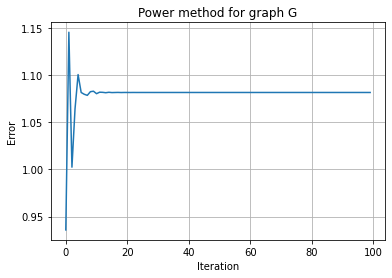

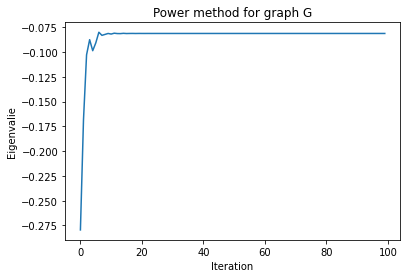

[-0.39970035  0.74668878 -0.32830706  0.06629794 -1.41004638]
[(1+0j), (1+0j), (-0.5+0.49999999999999983j), (-0.5-0.49999999999999983j), (-1+0j)]
-0.08138896104668825


In [7]:
import matplotlib.pyplot as plt

G = np.asarray([[0, 1, 0, 0, 0],
                [0, 0, 1, 0, 0],
                [1, 1, 0, 0, 0],
                [0, 0, 0, 0, 1],
                [0, 0, 0, 1, 0]], dtype='double')

A = pagerank_matrix(G)
initial_guess = np.random.randn(G.shape[1])
iters = 100
lviter = []

for iter in range(iters):
    _, l, res = power_method(A, initial_guess, iter)
    lviter.append(l)
    
plt.plot(res)
plt.title('Power method for graph G')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.grid()
plt.show()

    
plt.plot(lviter)
plt.title('Power method for graph G')
plt.xlabel('Iteration')
plt.ylabel('Eigenvalie')
plt.show()


print(initial_guess)
print(sorted(np.linalg.eigvals(A), reverse=True))
print(l)

[src](https://www.cs.huji.ac.il/~csip/tirgul2.pdf)

In a general case, if se suppose A to be square and diagonalizible, matrix A has n independent eigenvectors: $x_1, x_2 \dots x_n$. 

For any vector $v$ in a basis of eigenvectors, $v = a_1x_1 + \dots + a_nx_n$. Let us take $v_{(0)}$ as an initial guess for the power method. Then, the $k$'th iteration of the power methot yields:
$$
\begin{aligned}
A^{k} v_{(0)} &=A^{k}\left(a_{1} x_{1}+a_{2} x_{2}+\cdots+a_{n} x_{n}\right)=a_{1} A^{k} x_{1}+a_{2} A^{k} x_{2}+\ldots+a_{n} A^{k} x_{n} \\
&=a_{1} \lambda_{1}^{k} x_{1}+a_{2} \lambda_{2}^{k} x_{2}+\ldots+a_{n} \lambda_{n}^{k} x_{n}=a_{1} \lambda_{1}^{k}\left(x_{1}+\sum_{j=2}^{n} \frac{a_{j}}{a_{1}}\left(\frac{\lambda_{j}}{\lambda_{1}}\right)^{k} x_{j}\right)
\end{aligned}
$$

For this specific graph, $\lambda_1 = \lambda_2$. if we plug in $\frac{\lambda_2)}{\lambda_1} = 1$ to the formula above, we gonna see that the value of matrix-vector multiplication is unchanged from iteration to iteration, hence no convergence as the Sum part does not decay with $k\rightarrow\infty$


* (2 pts) Consider the same graph, but with additional self loop at node 4 (self loop is an edge that connects a vertex with itself). Plot residuals as in the previous task and discuss the convergence. Now, run the power method with ```num_iter=100``` for 10 different initial guesses and print/plot the resulting approximated eigenvectors. Why do they depend on the initial guess?

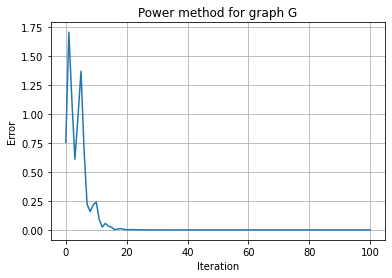

array([-0.30305994, -0.30305994, -0.30305994, -0.60185714, -0.60185714])

In [8]:
import matplotlib.pyplot as plt

G = np.asarray([[0, 1, 0, 0, 0],
                [0, 0, 1, 0, 0],
                [1, 1, 0, 0, 0],
                [0, 0, 0, 1, 1],
                [0, 0, 0, 1, 0]], dtype='double')

B = pagerank_matrix(G)
initial_guess = np.random.randn(G.shape[1])
iters = 100

x, l, res = power_method(B, initial_guess, iters)

plt.plot(res)
plt.title('Power method for graph G')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.grid()
plt.show()
l
x

In [9]:
xs = np.empty((10, (B.shape[1])))
for i in range(10):
    gs = np.random.randn(B.shape[1])
    x, l, _ = power_method(B, gs, 100)
    xs[i] = x
    print(l)
print(xs)
print(np.linalg.eig(B)[1][2])
print(np.linalg.eig(B)[1][3])
""" The largest eigenvalue here is stoll non-unique, which results in 
incorrect computation of eigenvectors, 
although the residual values and the largest eigenvalue are in place """

1.0000000000000002
0.9999999999999983
1.0000000000000002
0.999999999999999
1.0000000000000004
1.0000000000000002
1.0
0.9999999999999998
1.0000000000000002
1.0000000000000002
[[ 0.36323508  0.36323508  0.36323508  0.54962752  0.54962752]
 [-0.57719054 -0.57719054 -0.57719054 -0.01663206 -0.01663206]
 [ 0.14875098  0.14875098  0.14875098  0.68323475  0.68323475]
 [-0.46338488 -0.46338488 -0.46338488  0.42179578  0.42179578]
 [-0.12402879 -0.12402879 -0.12402879  0.69059778  0.69059778]
 [-0.48847641 -0.48847641 -0.48847641 -0.37694323 -0.37694323]
 [ 0.05478303  0.05478303  0.05478303  0.70391635  0.70391635]
 [ 0.52657103  0.52657103  0.52657103 -0.28997314 -0.28997314]
 [ 0.40502608  0.40502608  0.40502608  0.50391548  0.50391548]
 [ 0.50718409  0.50718409  0.50718409 -0.33785566 -0.33785566]]
[-1.07548826e-16-0.37796447j -1.07548826e-16+0.37796447j
 -5.77350269e-01+0.j          0.00000000e+00+0.j
  0.00000000e+00+0.j        ]
[ 0.        +0.j  0.        -0.j  0.        +0.j  0.7071067

' The largest eigenvalue here is stoll non-unique, which results in \nincorrect computation of eigenvectors, \nalthough the residual values and the largest eigenvalue are in place '

In order to avoid this problem Larry Page and Sergey Brin [proposed](http://ilpubs.stanford.edu:8090/422/1/1999-66.pdf) to use the following regularization technique:

$$
A_d = dA + \frac{1-d}{N} \begin{pmatrix} 1 & \dots & 1 \\ \vdots & & \vdots \\ 1 & \dots & 1 \end{pmatrix},
$$

where $d$ is a small parameter in $[0,1]$ (typically $d=0.85$), which is called **damping factor**, $A$ is of size $N\times N$. Now $A_d$ is the matrix with multiplicity of the largest eigenvalue equal to 1. 
Recall that computing the eigenvector of the PageRank matrix, which corresponds to the largest eigenvalue, has the following interpretation. Consider a person who stays in a random node of a graph (i.e. opens a random web page); at each step s/he follows one of the outcoming edges uniformly at random (i.e. opens one of the links). So the person randomly walks through the graph and the eigenvector we are looking for is exactly his/her stationary distribution â€” for each node it tells you the probability of visiting this particular node. Therefore, if the person has started from a part of the graph which is not connected with the other part, he will never get there.  In the regularized model, the person at each step follows one of the outcoming links with probability $d$ OR teleports to a random node from the whole graph with probability $(1-d)$.

* (2 pts) Now, run the power method with $A_d$ and plot residuals $\|A_d x_k - \lambda_k x_k\|_2$ as a function of $k$ for $d=0.97$, ```num_iter=100``` and a random initial guess ```x0```.

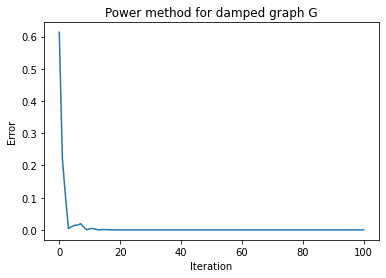

In [10]:
def damp(A, d=0.85):
    return d * A + ((1 - d) / A.shape[0]) * np.ones(A.shape)
    
Bd = damp(B, 0.97)

x, l, res = power_method(Bd, np.random.randn(Bd.shape[0]), 100)
plt.plot(res)
plt.title('Power method for damped graph G')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.show()

* (5 pts) Find the second largest in the absolute value eigenvalue of the obtained matrix $A_d$. How and why is it connected to the damping factor $d$? What is the convergence rate of the PageRank algorithm when using damping factor?

In [11]:
eigs = sorted(abs(np.linalg.eig(B)[0]), reverse=True)
neweigs = sorted(abs(np.linalg.eig(Bd)[0]), reverse=True)
print(eigs)
print(neweigs)
print(abs(neweigs[1])/eigs[1])
print(abs(neweigs[2])/eigs[2])
print(abs(neweigs[3])/eigs[3])
print(abs(neweigs[4])/eigs[4])
""" the damping makes the new matrix with a uinque largest eigenvalue. 
if we suppose an array of sorted abs(eigen), 
damping makes every eigen_i i>1 such that neweigen_i = d*eigen_i"""

[1.0, 1.0, 0.7071067811865475, 0.7071067811865475, 0.5]
[1.0000000000000009, 0.9699999999999999, 0.6858935777509511, 0.6858935777509511, 0.4849999999999999]
0.9699999999999999
0.97
0.97
0.9699999999999998


' the damping makes the new matrix with a uinque largest eigenvalue. \nif we suppose an array of sorted abs(eigen), \ndamping makes every eigen_i i>1 such that neweigen_i = d*eigen_i'

Usually, graphs that arise in various areas are sparse (social, web, road networks, etc.) and, thus, computation of a matrix-vector product for corresponding PageRank matrix $A$ is much cheaper than $\mathcal{O}(N^2)$. However, if $A_d$ is calculated directly, it becomes dense and, therefore, $\mathcal{O}(N^2)$ cost grows prohibitively large for  big $N$.

* (2 pts) Implement fast matrix-vector product for $A_d$ as a function ```pagerank_matvec(A, d, x)```, which takes a PageRank matrix $A$ (in sparse format, e.g., ```csr_matrix```), damping factor $d$ and a vector $x$ as an input and returns $A_dx$ as an output. 

In [12]:
from scipy import sparse

# INPUT:  A - np.ndarray (2D), d - float (from 0.0 to 1.0), x - np.ndarray (1D, size of A.shape[0/1])
# OUTPUT: y - np.ndarray (1D, size of x)
def pagerank_matvec(A, d, x): # 2 pts
    if not isinstance(A, sparse.spmatrix):
        A = sparse.csc_matrix(A)
    dA = d*A
    tmp1 = dA @ x
    tmp2 = ((1 - d) / A.shape[0]) * x 
    if type(tmp1) == type(np.ndarray(1)):
        return tmp1 + tmp2.sum()
    return tmp1.toarray() + tmp2.sum()

""" naive Ad.dot(x) tolls the RAM. There is a workaround. """
# Ad = damp(A, 0.97)
# %timeit -n 2 Ad.dot(x)
def notnaive_direct(A, d, x):
    A = A.toarray()
    return d * A @ x + (1 - d) / A.shape[0] * x.sum()

* (1 pts) Generate a random adjacency matrix of size $10000 \times 10000$ with only 100 non-zero elements and compare ```pagerank_matvec``` performance with direct evaluation of $A_dx$.

In [13]:
A = sparse.random(10000, 10000, density=0.000001,format='csc')
A.data = np.ceil(A.data)
A = pagerank_matrix(A)
x = sparse.csr_matrix(np.random.rand(10000, 1))
A

<10000x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 100 stored elements in Compressed Sparse Column format>

In [14]:
%timeit -n 2 pagerank_matvec(A, 0.97, x)
# pagerank_matvec(A, 0.97, x)

741 µs ± 232 µs per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [13]:
%timeit -n 2 notnaive_direct(A, 0.97, x)
# notnaive_direct(A, 0.97, x)

370 ms ± 5.42 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [15]:
""" pagerank_matvec is approximaately 350 times more efficient than a direct approach """

""" below we check if functions' output are valid for small N"""
B = sparse.random(10000, 10000, density=1,format='csc')
xx = sparse.csr_matrix(np.random.rand(10000, 1))

foo1 = pagerank_matvec(B, 0.97, xx)
foo2 = notnaive_direct(B, 0.97, xx)
foo3 = damp(B, 0.97).dot(xx.todense())
print(all(np.isclose(foo1, foo3)))
print(all(np.isclose(foo2, foo3)))

True
True


#### DBLP: computer science bibliography

Download the dataset from [here](https://goo.gl/oZVxEa), unzip it and put `dblp_authors.npz`  and `dblp_graph.npz` in the same folder with this notebook. Each value (author name) from `dblp_authors.npz` corresponds to the row/column of the matrix from `dblp_graph.npz`. Value at row `i` and column `j` of the matrix from `dblp_graph.npz` corresponds to the number of times author `i` cited papers of the author `j`. Let us now find the most significant scientists according to PageRank model over DBLP data.

* (4 pts) Load the weighted adjacency matrix and the authors list into Python using ```load_dblp(...)``` function. 
    - Print its density (fraction of nonzero elements). 
    - Find top-10 most cited authors from the weighted adjacency matrix. 
        - Now, make all the weights of the adjacency matrix equal to 1 for simplicity (consider only existence of connection between authors, not its weight). 
    - Obtain the PageRank matrix $A$ from the adjacency matrix and verify that it is stochastic.
 
 

In [16]:
from scipy.sparse import load_npz, linalg
import numpy as np

def load_dblp(path_auth, path_graph):
    G = load_npz(path_graph).astype(float)
    with np.load(path_auth) as data: authors = data['authors']
    return G, authors

G, authors = load_dblp('dblp_authors.npz', 'dblp_graph.npz')

In [17]:
G

<1766547x1766547 sparse matrix of type '<class 'numpy.float64'>'
	with 140388901 stored elements in Compressed Sparse Row format>

In [18]:
nonzeros = G.getnnz()
fullmat = np.prod(G.shape)

density = nonzeros / fullmat
print("The density of the matrix is {}".format(density))

The density of the matrix is 4.4986518152305776e-05


In [19]:
citations = G.sum(0).tolist()[0]
citations_dic = {author:incoming_cit for author, incoming_cit in enumerate(citations)}
citations_dct = list(sorted(citations_dic.items(), key=lambda item: item[1], reverse = True))

In [20]:
authors_list = authors.tolist()
for auth_id, incoming_citations in citations_dct[:10]:
    print("{:20s} has {} \t incoming citations".format(authors_list[auth_id], incoming_citations))
    

Scott Shenker        has 119853.0 	 incoming citations
Andrew Zisserman     has 118558.0 	 incoming citations
Hari Balakrishnan    has 117253.0 	 incoming citations
Jiawei Han           has 116708.0 	 incoming citations
Anil K. Jain         has 113874.0 	 incoming citations
Cordelia Schmid      has 102996.0 	 incoming citations
Jitendra Malik       has 101657.0 	 incoming citations
Ion Stoica           has 98017.0 	 incoming citations
David E. Culler      has 95762.0 	 incoming citations
David G. Lowe        has 93678.0 	 incoming citations


In [21]:
nnz_idx = G.nonzero()
G[nnz_idx] = 1

In [100]:
A = pagerank_matrix(G)
col_sums = np.array(A.sum(axis=1).tolist())

In [86]:
for summ in col_sums:
    if (summ !=0) and (not np.isclose(summ, 1)):
        raise Exception("Matrix is not stochastic")
print("Matrix is stochastic")

Matrix is stochastic


* (1 pts) In order to provide ```pagerank_matvec``` to your ```power_method``` (without rewriting it) for fast calculation of $A_dx$, you can create a ```LinearOperator```: 
```python
L = scipy.sparse.linalg.LinearOperator(A.shape, matvec=lambda x, A=A, d=d: pagerank_matvec(A, d, x))
```
    Calling ```L@x``` or ```L.dot(x)``` will result in calculation of ```pagerank_matvec(A, d, x)``` and, thus, you can plug $L$ instead of the matrix $A$ in the ```power_method``` directly. **Note:** though in the previous subtask graph was very small (so you could disparage fast matvec implementation), here it is very large (but sparse), so that direct evaluation of $A_dx$ will require $\sim 10^{12}$ matrix elements to store - good luck with that (^_<).
    

* (2 pts) Run the power method starting from the vector of all ones and plot residuals $\|A_dx_k - \lambda_k x_k\|_2$  as a function of $k$ for $d=0.85$.

In [35]:
d = 0.85
A=A.T
L = linalg.LinearOperator(A.shape, matvec=lambda x, A=A, d=d: pagerank_matvec(A, d, x))


x, l, res = power_method(L, np.ones(A.shape[0]), 100)

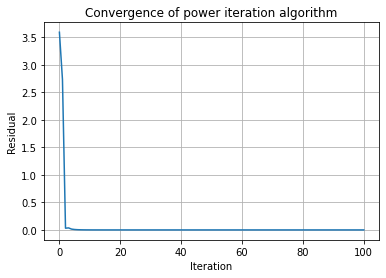

In [36]:
plt.plot(range(101), res)
plt.xlabel("Iteration")
plt.ylabel("Residual")
plt.title("Convergence of power iteration algorithm")
plt.grid()
plt.show()

* (1 pts) Print names of the top-10 authors according to PageRank over DBLP when $d=0.85$. Comment on your findings.

In [134]:
t10 = x.argsort()[-10:][::-1]
for i in t10:
    print(citations_dic[i], authors_list[i])

69065.0 David E. Goldberg
52514.0 Richard M. Karp
21487.0 John E. Hopcroft
25040.0 Azriel Rosenfeld
40375.0 Ronald L. Rivest
113874.0 Anil K. Jain
77359.0 Takeo Kanade
18233.0 Alfred V. Aho
44114.0 Robert Endre Tarjan
45703.0 Gerard Salton


In [131]:
t100 = x.argsort()[-100:][::-1]
cits = []
auth = []
for i in t100:
    cits.append(citations_dic[i])
    auth.append(authors_list[i])

t10 = sorted(zip(cits, auth), reverse=True)[:10]
print(*t10,sep="\n")
""" The space is multidimensional, so it is quite hard to calculate an exact eigenvector. 
So i've elected to pick top 10 of the 100 coordinates with largest magnitude.
The list in this way is not exact, but it is a close approximate"""

(119853.0, 'Scott Shenker')
(118558.0, 'Andrew Zisserman')
(117253.0, 'Hari Balakrishnan')
(116708.0, 'Jiawei Han')
(113874.0, 'Anil K. Jain')
(101657.0, 'Jitendra Malik')
(98017.0, 'Ion Stoica')
(95762.0, 'David E. Culler')
(93678.0, 'David G. Lowe')
(92448.0, 'Ian T. Foster')


" The space is multidimensional, so it is quite hard to calculate an exact eigenvector. \nSo i've elected to pick top 10 of the 100 coordinates with largest magnitude.\nThe list in this way is not exact, but it is a close approximate"

## Problem 3. QR algorithm (33 pts)

* Implement QR-algorithm without shifts. Prototype of the function is given below

In [96]:
from scipy.sparse import diags

# INPUT: 
# A_init - square matrix, 
# num_iter - number of iterations for QR algorithm
# OUTPUT: 
# Ak - transformed matrix A_init given by QR algorithm, 
# convergence - numpy array of shape (num_iter, ), 
# where we store the maximal number from the Chebyshev norm 
# of triangular part of the Ak for every iteration
def qr_algorithm(A_init, num_iter): # 3 pts
    Ak = A_init
    convergence = []
    for k in range(num_iter):
        Q,R = np.linalg.qr(Ak, mode='complete')
        convergence.append(np.linalg.norm(np.tril(Ak, -1), ord=np.inf))
        Ak = Q.T @ Ak @ Q
    convergence = np.array(convergence)
    return Ak, convergence

#### Symmetric case (3 pts)
- Create symmetric tridiagonal $11 \times 11$ matrix with elements $-1, 2, -1$ on sub-, main- and upper diagonal respectively without using loops.
- Run $400$ iterations of the QR algorithm for this matrix.
- Plot the output matrix with function ```plt.spy(Ak, precision=1e-7)```.
- Plot convergence of QR-algorithm.

array([[ 2., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1.,  2., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  2., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  2., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  2., -1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  2., -1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  2., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  2., -1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  2., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  2., -1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  2.]])

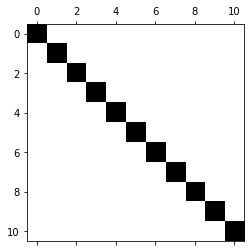

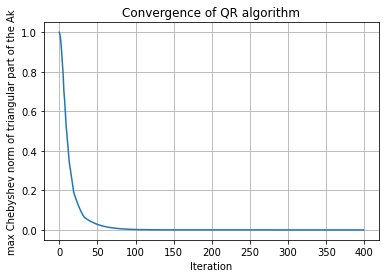

In [97]:
diag_broadcast = [-1,2,-1]

diagonals = [np.full(11,diag_broadcast[1]), 
             np.full(10,diag_broadcast[0]), 
             np.full(10,diag_broadcast[2])]
A_init = diags(diagonals, [0, -1, 1]).toarray()

Ak, convergence = qr_algorithm(A_init, 400)
plt.spy(Ak, precision=1e-7)

plt.figure()
plt.plot(range(400), convergence)
plt.xlabel("Iteration")
plt.ylabel("max Chebyshev norm of triangular part of the Ak")
plt.title("Convergence of QR algorithm")
plt.grid()
A_init

#### Nonsymmetric case (5 pts)

- Create nonsymmetric tridiagonal $11 \times 11$ matrix with elements $5, 3, -2$ on sub-, main- and upper diagonal respectively without using loops.
- Run $250$ iterations of the QR algorithm for this matrix.
- Plot the result matrix with function ```plt.spy(Ak, precision=1e-7)```. Is this matrix lower triangular? How does this correspond to the claim about convergence of the QR algorithm?

array([[ 3., -2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 5.,  3., -2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  5.,  3., -2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  5.,  3., -2.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  5.,  3., -2.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  5.,  3., -2.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  5.,  3., -2.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  5.,  3., -2.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  5.,  3., -2.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  5.,  3., -2.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  5.,  3.]])

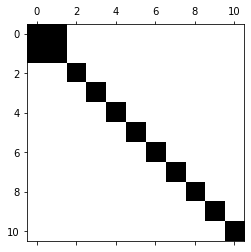

In [82]:
diag_broadcast = np.array([5,3,-2])
diagonals = [np.full(11,diag_broadcast[1]), 
             np.full(10,diag_broadcast[0]), 
             np.full(10,diag_broadcast[2])]

A = diags(diagonals, [0, -1, 1]).toarray()

Ak, convergence = qr_algorithm(A_init, 250)
plt.spy(Ak, precision=1e-7)
A

### QR algorithms with Rayleigh Quotient shift (10 pts)

In the lectures the Rayleigh Quotient shift was introduced to speed up convergence of power method. Here we ask you to generalize this approach to construct the shifts in QR algorithm.

- How to compute the Rayleigh Quotient shift in QR algorithm fast? Provide formulas and explanations how they can be simplified.
- Implement explicit QR algorithm with Rayleigh Quotient shift. Please do not worry about implicit orthogonalization, we want to compare convergence only in terms of iterations.
- Test your implementation in the symmetric case. Plot the convergence of QR algorithm with and without shift. Choose the dimension $n \sim 100 $ for more representative results. 
- How the convergence of the shifted algorithm compares to the simple QR? Why? 

In [1]:
def qr_algorithm_reileigh(A_init, num_iter):
    # enter your code here
    return Ak, convergence

- Try QR with Rayleigh Quotient shift for a simple matrix $A = \begin{bmatrix}
0 & 1 \\
1 & 0
\end{bmatrix}$. Does anything change from iteration to iteration? Does shift affect convergence here? Why?

In [ ]:
# Your solution is here

### QR with Wilkinson shift  (15 pts)

To solve the problem that appears in the last example, we can use the Wilkinson shift:

$$\mu = a_m - \frac {sign(\delta) b^2_{m-1}} {(|\delta| + \sqrt{\delta^2 + b^2_{m-1}} )},$$

where $\delta = \frac{(a_{m-1} - a_m)}{2}$. If $\delta = 0$, then instead of $sign(\delta)$ you have to choose $1$ or $-1$ arbitrary.
The numbers $a_m, b_{m-1}, a_{m-1}$ are taken from matrix $B$:

$$
    B = 
    \begin{bmatrix} 
     a_{m-1} & b_{m-1} \\ 
     b_{m-1} & a_m \\ 
    \end{bmatrix},
$$  
which is a lower right bottom submatrix of $A^{(k)}$. Here $k$ is an iteration counter in QR algorithm.

- Compare convergence in the symmetric cases: 
    - distinctive eigenvalues
    - two coincident eigenvalues
    - maximum and minimum eigenvalues with the same absolute value
Choose the dimension $n \sim 100 $ for more representative results.
What do you observe? 

In [ ]:
def qr_algorithm_wilkinson(A_init, num_iter):
    # enter your code here
    return Ak, convergence

In [ ]:
# Your solution is here

## Problem 4. (Movie Recommender system) 15 pts

Imagine the world without NLA where you have free evenings and you can watch movies!  
But it is always hard to choose a movie to watch. 
In this problem we suggest you to build your own movie recommender system based on SVD decomposition, so you can combine two perfect things: Numerical Linear Algebra and cinematography!

In order to build recommender system you need data. 
Here you are https://grouplens.org/datasets/movielens/1m/

Usually all recommender systems may be devided into two groups

#### Collaborative filtering. 

This approach is based on user-item interaction.
It has one important assumption: user who has liked an item in the past will also likes the same in the future. Suppose the user A likes the films about vampires. 
He is Twilight saga fan and he has watched the film "What we do in the shadows" and liked it or unliked it, in other words he evaluated it somehow. And suppose another user B, who has the similair behavior to the first user (he is also Twilight saga fan). And the chance, that he will estimate "What we do in the shadows" in the same way that user A did, is huge. So, the purpose of the collaborative filtering is to predict a user's behavior based on behavior of the simular users.

#### Content based filtering.

Collaborative filtering has some essential flaws. The main one is called "cold start". "Cold start" happens when the new user comes and he has not react anyhow to the items. So we do not know his past behavior and we do not know what to advise. Here content based filtering helps. Often resources gather some extra info about users and items before a user comes down to utilising the resource. So, for example we would know that user likes horror movies before he watched anything on the resource.


- In this task you will implement Collaborative filtering based on SVD (we will use the function from the proper package and check if the result recommender system advices the similar movies)

1) (1 pts)  Explore the data. Construct the interaction matrix $M$ of size $m \times n$ which contains the information of how a certain user rated a certain film. 

In [94]:
import csv
import os
import pandas as pd

def convert2csv(folder, file):
    path = os.path.join(folder, file)
    datContent = [i.strip().split() for i in open(path, encoding='latin-1').readlines()]
    
    file_csv = file.split('.')[0] +'.csv'
    # write it as a new CSV file
    with open(os.path.join(folder, file_csv), "w") as f:
        writer = csv.writer(f)
        writer.writerows(datContent)
        
for f in ['movies.dat','users.dat','ratings.dat']:        
    convert2csv('./ml-1m/',f)

df_movies = pd.read_csv("./ml-1m/movies.csv", sep = '::', header = None)
columns = "MovieID::Title::Genres".split("::")
df_movies.columns = columns

df_users = pd.read_csv("./ml-1m/users.csv", sep = '::', header = None)
cols = "UserID::Gender::Age::Occupation::Zip-code".split("::")
df_users.columns = cols

df_ratings = pd.read_csv("./ml-1m/ratings.csv", sep = '::', header = None)
rating_col = "UserID::MovieID::Rating::Timestamp".split("::")
df_ratings.columns =rating_col 

In [58]:
import re
movieid = {}
moviename = {}
for mid, mti in zip(df_movies['MovieID'].tolist(), 
                    df_movies['Title'].tolist()):
    mid = re.sub("[^\d]","",str(mid))
    if mid not in movieid:
        movieid[mid] = len(mid)
        moviename[len(movieid)] = mti
        
for mid in df_ratings['MovieID'].tolist():
    mid = re.sub("[^\d]","",str(mid))
    if mid not in movieid:
        movieid[movid] = len(movieid)
        moviename[len(movieid)] = 'NaName'

uidid = {}
for uid in df_users['UserID'].tolist():
    uid = re.sub("[^\d]","",str(uid))
    if uid not in uidid:
        uidid[uid] = len(uidid)
        
for uid in df_ratings['UserID'].tolist():
    uid = re.sub("[^\d]","",str(uid))
    if uid not in uidid:
        uidid[uid] = len(uidid)

In [64]:
interactionMtx = np.zeros((len(uidid),len(movieid)))
for i, j in df_ratings.iterrows():

    user_id = re.sub("[^\d]","",str(j['UserID']))
    movie_id = re.sub("[^\d]","",str(j['MovieID']))
    
    user_id = uidid[user_id]
    movie_id = movieid[movie_id]
    
    interactionMtx[user_id,movie_id] = j['Rating']

In [65]:
interactionMtx

array([[0., 5., 5., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 3., ..., 0., 0., 0.],
       [0., 3., 5., ..., 0., 0., 0.]])

2) (5 pts)  Compute SVD of this matrix. Remeber that matrix $M$ is sparse (one user can hardly watch all the movies) so the good choice would be to use method from ```scipy.sparse.linalg``` package

$$ M = USV^{\top}, $$

where $U$ is a $m \times r $ orthogonal matrix with left singular vectors, which represents the relationship between users and latent factors, $S$ is a $r \times r $ diagonal matrix, which describes the strength of each latent factor and $V^\top$ is a $r \times n$ matrix with right singular vectors, which represent the embeddings of  items (movies in our case) in latent space.
Describe any simple heuristic to choose appropriate value for $r$ and explain why do you expect that it will work.

In [92]:
import scipy.sparse

spIntMtx = sparse.csc_matrix(interactionMtx)

U,S, V = sparse.linalg.svds(spIntMtx)

3) (2 pts) In order to get weighted item-latent factors, we can multiply $S$ and $V^{T}$. Please, remember that $S$ is diagonal and multiply them efficiently.

In [90]:
Smat = sparse.diags(sorted(S,reverse=True))

print(U.shape)
print(Smat.shape)
print(V.shape)

print((Smat@V).shape)

(6040, 6)
(6, 6)
(6, 3883)
(6, 3883)


Now we have vectors that represent our item space. In other words we have $N$ movies and $N$ vectors which describe each movie, a.k.a. embeddings. 
In order to know if two movies are similar or not we need just to check if the corresponding vectors are similair or not. How we can do this?

4) (2 pts)  Implement the cosine metric. If the cosine metric between two vectors equals to $1$ both vectors are collinear, if $0$ vectors are orthogonal, as a result corresponding movies are completely different.

$$
cosine(u,v) = \frac{u^{\top}v}{\|u\|_2\|v\|_2}
$$

In [91]:
def cosine_metric(v1, v2):
    return v1.T.dot(v2) / (np.linalg.norm(v1, ord=2) * np.linalg.norm(v2, ord=2))

5) (5 pts) Check your result. Implement the fuction, which finds and prints $k$ similar movies to the one you have chosen

In [ ]:
# Your solutuion is here

Enjoy watching the recommended movies!
